<a href="https://colab.research.google.com/github/Potato-Miyaw/Addressing-Bias-and-Hallucination-in-LLM-Based-Resume-Assessment-Models/blob/main/notebooks/hallucination_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3: Hallucination Detection Methods Comparison

**Student:** Syed Rayan Alam NASSER   
**Group:** DSA 9  

---

## 1. Introduction

### Research Context

This task investigates automated hallucination detection techniques for Large Language Model (LLM) outputs in resume extraction contexts. Recent research (Huang et al., 2024) shows hallucination rates of 8-15% in LLM resume extraction tasks, creating significant trust and reliability concerns in automated hiring systems.

**Relevant Papers:**
- Hallucination detection survey (Huang et al., 2024)
- Semantic similarity methods (BERTScore)
- Natural Language Inference approaches
- Ensemble detection techniques

**Research Gap:** While hallucination detection is well-studied in general NLP, systematic comparison of detection methods for structured information extraction (resume parsing) remains unexplored.

### Objectives

1. Compare effectiveness of automated hallucination detection methods
2. Evaluate trade-offs between detection accuracy and computational cost
3. Identify optimal detection approach for production resume screening systems
4. Achieve target hallucination detection rate >80% F1

### Research Question

**Primary:** Which automated hallucination detection method most effectively identifies LLM-generated misinformation in resume extraction while maintaining acceptable computational efficiency?

**Secondary:** How do semantic similarity methods (BERTScore) compare to logical inference methods (NLI) in detecting different hallucination types (intrinsic vs. extrinsic)?

---

## 2. Setup


### Environment Configuration

**Platform:** Google Colab (T4 GPU)  
**Python Version:** 3.10  
**Key Libraries:** Transformers 4.36, PyTorch 2.1, NLTK 3.8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/task3_hallucination
%cd /content/drive/MyDrive/task3_hallucination

print("Project folder created!")

Mounted at /content/drive
/content/drive/MyDrive/task3_hallucination
Project folder created!


### Reproducibility Settings

In [ ]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


### Library Installation

In [ ]:
!pip install -q google-generativeai transformers torch accelerate \
    bert-score nltk scikit-learn statsmodels matplotlib seaborn \
    pandas numpy tqdm kagglehub

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


True

### Core Imports

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import re
import time
import kagglehub
import warnings
import sys
from tqdm import tqdm
from collections import Counter

# Deep learning
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bertscore_compute
from huggingface_hub import login

# NLP
from nltk.tokenize import word_tokenize

# Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    roc_auc_score,
    make_scorer
)
from statsmodels.stats.contingency_tables import mcnemar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

os.environ['JUPYTER_WIDGETS_STATE'] = '0'

----

## 3. Data Loading & Exploration


### Dataset Source

**Dataset:** Kaggle AI-Powered Resume Screening 2025  
**URL:** https://www.kaggle.com/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025  
**Size:** 1000 resumes total, using 100 for this task  
**Fields:** Resume_ID, Name, Skills, Experience, Education, Certifications, Job Role, Projects Count, AI Score

### Load Dataset

In [ ]:
# Download dataset
dataset_dir = kagglehub.dataset_download(
    "mdtalhask/ai-powered-resume-screening-dataset-2025"
)
csv_path = os.path.join(dataset_dir, "AI_Resume_Screening.csv")

# Load data
df = pd.read_csv(csv_path)

print(f"Dataset loaded: {len(df)} resumes")
print(f"\nColumns: {list(df.columns)}")
print(f"\nDataset Info:")
print(df.info())

100%|██████████| 22.8k/22.8k [00:00<00:00, 7.97MB/s]

Extracting files...
Dataset loaded: 1000 resumes

Columns: ['Resume_ID', 'Name', 'Skills', 'Experience (Years)', 'Education', 'Certifications', 'Job Role', 'Recruiter Decision', 'Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score

### Data Exploration

In [ ]:
# Display first few rows
print("\nSample resumes:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nExperience distribution:")
print(df['Experience (Years)'].describe())

print("\nEducation distribution:")
print(df['Education'].value_counts())

print("\nTop skills:")
all_skills = ','.join(df['Skills'].dropna()).split(',')
skill_counts = pd.Series([s.strip() for s in all_skills]).value_counts()
print(skill_counts.head(10))


Sample resumes:
   Resume_ID              Name                                        Skills  \
0          1        Ashley Ali                      TensorFlow, NLP, Pytorch   
1          2      Wesley Roman  Deep Learning, Machine Learning, Python, SQL   
2          3     Corey Sanchez         Ethical Hacking, Cybersecurity, Linux   
3          4  Elizabeth Carney                   Python, Pytorch, TensorFlow   
4          5        Julie Hill                              SQL, React, Java   

   Experience (Years) Education                Certifications  \
0                  10      B.Sc                           NaN   
1                  10       MBA                     Google ML   
2                   1       MBA  Deep Learning Specialization   
3                   7    B.Tech                 AWS Certified   
4                   4       PhD                           NaN   

                Job Role Recruiter Decision  Salary Expectation ($)  \
0          AI Researcher               H

### Visualization of Dataset

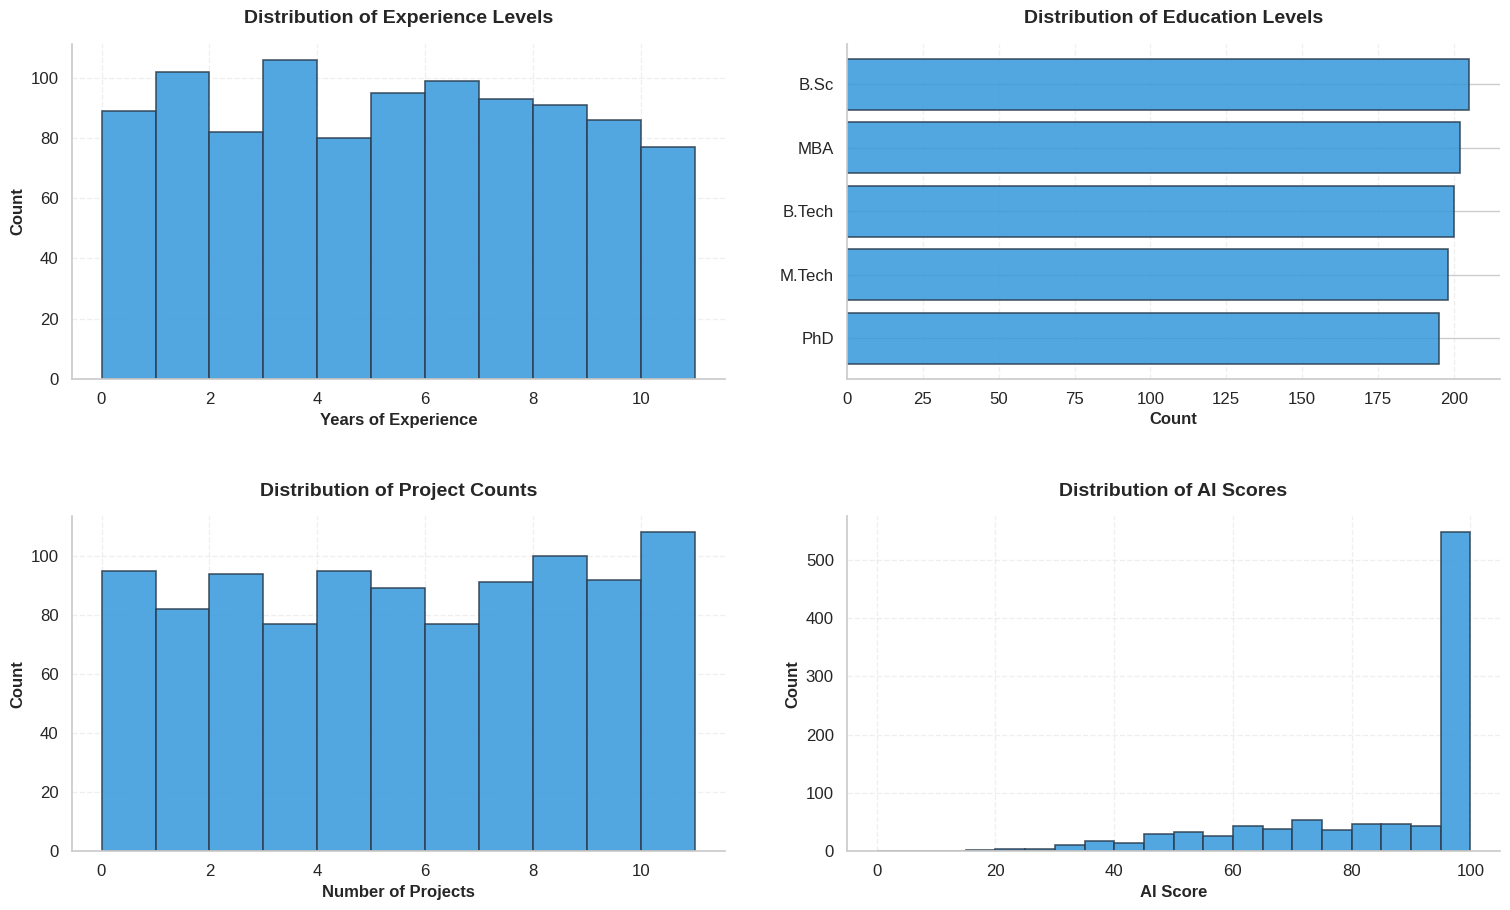

Visualization saved: dataset_exploration.png


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.patch.set_facecolor('white')

primary_color = '#3498db'
edge_color = '#2c3e50'

axes[0, 0].hist(df['Experience (Years)'],
                bins=range(0, int(df['Experience (Years)'].max()) + 2),
                color=primary_color,
                edgecolor=edge_color,
                linewidth=1.2,
                alpha=0.85,
                rwidth=1.0)
axes[0, 0].set_xlabel('Years of Experience', fontsize=12, fontweight='600')
axes[0, 0].set_ylabel('Count', fontsize=12, fontweight='600')
axes[0, 0].set_title('Distribution of Experience Levels', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)

education_counts = df['Education'].value_counts().sort_values(ascending=True)
axes[0, 1].barh(education_counts.index, education_counts.values,
                color=primary_color, edgecolor=edge_color, linewidth=1.2, alpha=0.85)
axes[0, 1].set_xlabel('Count', fontsize=12, fontweight='600')
axes[0, 1].set_title('Distribution of Education Levels', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].grid(True, alpha=0.3, linestyle='--', axis='x')
axes[0, 1].spines['top'].set_visible(False)
axes[0, 1].spines['right'].set_visible(False)

axes[1, 0].hist(df['Projects Count'],
                bins=range(0, int(df['Projects Count'].max()) + 2),
                color=primary_color,
                edgecolor=edge_color,
                linewidth=1.2,
                alpha=0.85,
                rwidth=1.0)
axes[1, 0].set_xlabel('Number of Projects', fontsize=12, fontweight='600')
axes[1, 0].set_ylabel('Count', fontsize=12, fontweight='600')
axes[1, 0].set_title('Distribution of Project Counts', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

axes[1, 1].hist(df['AI Score (0-100)'],
                bins=range(0, 101, 5),
                color=primary_color,
                edgecolor=edge_color,
                linewidth=1.2,
                alpha=0.85,
                rwidth=1.0)
axes[1, 1].set_xlabel('AI Score', fontsize=12, fontweight='600')
axes[1, 1].set_ylabel('Count', fontsize=12, fontweight='600')
axes[1, 1].set_title('Distribution of AI Scores', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.savefig('dataset_exploration.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Visualization saved: dataset_exploration.png")

---

## 4. Preprocessing

### Create Extraction Tasks

Transform structured CSV data into resume text format suitable for LLM extraction.

In [ ]:
def create_resume_instances(df, num_samples=None):
    """
    Creates extraction tasks from a DataFrame of resume data.

    Each extraction task includes the raw resume text and a ground truth
    dictionary of expected extracted values, suitable for LLM processing.

    Args:
        df (pd.DataFrame): DataFrame containing resume data with columns like
                           'Resume_ID', 'Name', 'Skills', 'Experience (Years)',
                           'Education', 'Certifications', 'Job Role',
                           'Salary Expectation ($)', 'Projects Count',
                           'AI Score (0-100)'.
        num_samples (int, optional): The number of samples to use from the
                                     DataFrame. If None, all rows are used.
                                     Defaults to None.

    Returns:
        list: A list of dictionaries, where each dictionary represents an
              extraction task with 'resume_id', 'resume_text', and 'ground_truth' keys.
    """
    if num_samples:
        df_samples = df.head(num_samples).copy()
        print(f"Using {num_samples} samples from dataset")
    else:
        df_samples = df.copy()
        print(f"Using ALL {len(df)} samples from dataset")

    extraction_tasks = []

    for idx, row in df_samples.iterrows():
        resume_text = f"""
            Resume ID: {row['Resume_ID']}
            Name: {row['Name']}
            Skills: {row['Skills']}
            Experience: {row['Experience (Years)']} years
            Education: {row['Education']}
            Certifications: {row['Certifications']}
            Target Job Role: {row['Job Role']}
            Project Count: {row['Projects Count']}
            Salary Expectation: ${row['Salary Expectation ($)']}
            AI Score: {row['AI Score (0-100)']}/100
            Recruiter Decision: {row['Recruiter Decision']}
            """.strip()

        ground_truth = {
            'name': str(row['Name']),
            'skills': [s.strip() for s in str(row['Skills']).split(',')],
            'experience_years': int(row['Experience (Years)']),
            'education': str(row['Education']),
            'certifications': [s.strip() for s in str(row['Certifications']).split(',')
                             if s.strip() and s.lower() != 'none'],
            'target_role': str(row['Job Role']),
            'projects_count': int(row['Projects Count']),
            'salary_expectation': int(row['Salary Expectation ($)']),
            'ai_score': int(row['AI Score (0-100)'])
        }

        extraction_tasks.append({
            'resume_id': row['Resume_ID'],
            'resume_text': resume_text,
            'ground_truth': ground_truth
        })

    return extraction_tasks

extraction_tasks = create_resume_instances(df, num_samples=1000)

with open('extraction_tasks.json', 'w') as f:
    json.dump(extraction_tasks, f, indent=2)

print(f"\nCreated {len(extraction_tasks)} extraction tasks")
print(f"Estimated time: {len(extraction_tasks) * 0.5 / 60:.1f} minutes")
print(f"\nExample task:")
print(f"Resume ID: {extraction_tasks[0]['resume_id']}")
print(f"Name: {extraction_tasks[0]['ground_truth']['name']}")
print(f"\nResume Text Preview:")
print(extraction_tasks[0]['resume_text'][:100])
print(f"\nGround Truth:")
print(json.dumps(extraction_tasks[0]['ground_truth'], indent=2))

Using 1000 samples from dataset

Created 1000 extraction tasks
Estimated time: 8.3 minutes

Example task:
Resume ID: 1
Name: Ashley Ali

Resume Text Preview:
Resume ID: 1
            Name: Ashley Ali
            Skills: TensorFlow, NLP, Pytorch
            E

Ground Truth:
{
  "name": "Ashley Ali",
  "skills": [
    "TensorFlow",
    "NLP",
    "Pytorch"
  ],
  "experience_years": 10,
  "education": "B.Sc",
  "certifications": [
    "nan"
  ],
  "target_role": "AI Researcher",
  "projects_count": 8,
  "salary_expectation": 104895,
  "ai_score": 100
}


## Data Manipulation

### Noise Function

In [ ]:
def add_comprehensive_noise(resume_text):
    """
    Add realistic formatting variations, typos, inconsistencies.
    Makes extraction harder while keeping data valid.
    """

    if random.random() < 0.5:
        noise_type = random.choice(['formatting', 'typos', 'abbreviations', 'reordering'])

        if noise_type == 'formatting':

            if random.random() < 0.5:
                resume_text = re.sub(r'\$(\d{2,3})(\d{3})', r'$\1,\2', resume_text)
            else:
                resume_text = resume_text.replace(',', '')

            replacements = {
                'AI Score: ': random.choice(['Score: ', 'AI Rating: ', 'Assessment: ']),
                'Salary Expectation: ': random.choice(['Expected Salary: ', 'Salary: ', 'Compensation: ']),
                'Projects Completed: ': random.choice(['Projects: ', 'Total Projects: ', 'Project Count: ']),
                'Experience: ': random.choice(['Years of Experience: ', 'Work Experience: ', 'Total Experience: ']),
            }
            for old, new in replacements.items():
                if old in resume_text:
                    resume_text = resume_text.replace(old, new)

            if random.random() < 0.3:
                resume_text = resume_text.replace('\n', '\n\n', 1)

        elif noise_type == 'typos':

            typo_map = {
                'Projects Completed': 'Projects Complted',
                'Certifications': 'Certfications',
                'Experience': 'Experiance',
                'Education': 'Educaton',
                'Skills': 'Skils',
            }
            for correct, typo in typo_map.items():
                if correct in resume_text and random.random() < 0.3:
                    resume_text = resume_text.replace(correct, typo)

        elif noise_type == 'abbreviations':

            abbrev_map = {
                "Bachelor's": random.choice(["Bach.", "B.S.", "Bachelors"]),
                "Master's": random.choice(["Mast.", "M.S.", "Masters"]),
                "PhD": random.choice(["Ph.D", "Doctorate", "Doctor"]),
                "Bachelor of Technology": "B.Tech",
                "Bachelor of Science": "B.Sc",
                "Master of Technology": "M.Tech",
                "Master of Business Administration": "MBA",
            }
            for full, abbrev in abbrev_map.items():
                if full in resume_text:
                    resume_text = resume_text.replace(full, abbrev)

        elif noise_type == 'reordering':
            lines = resume_text.strip().split('\n')
            if len(lines) > 5:
                idx1, idx2 = random.sample(range(1, len(lines)), 2)
                lines[idx1], lines[idx2] = lines[idx2], lines[idx1]
                resume_text = '\n'.join(lines)

    return resume_text

print(" Formatting noise function defined")
print(" - Adds commas, changes labels, typos, abbreviations, reordering")

 Formatting noise function defined
 - Adds commas, changes labels, typos, abbreviations, reordering


### Field Removal Function

In [ ]:
def remove_random_fields(resume_text, ground_truth):
    """
    Remove some fields from resume text to simulate incomplete data.
    Forces model to handle missing information.

    NEVER remove: name, ai_score (critical fields)
    Sometimes remove: skills, certifications, education, etc.
    """

    removable_fields = [
        ('Experience:', 'experience_years'),
        ('Projects Completed:', 'projects_count'),
        ('Salary Expectation:', 'salary_expectation'),
        ('Education:', 'education'),
        ('Certifications:', 'certifications'),
        ('Skills:', 'skills'),
        ('Target Job Role:', 'target_role'),
    ]

    fields_removed = []

    for field_label, field_name in removable_fields:
        if random.random() < 0.3:
            pattern = f'{field_label}.*\n'
            resume_text = re.sub(pattern, '', resume_text)
            fields_removed.append(field_name)

    return resume_text, fields_removed

print(" Field removal function defined")
print(" - Randomly removes fields (30% chance each)")
print(" - Never removes: name, ai_score")

 Field removal function defined
 - Randomly removes fields (30% chance each)
 - Never removes: name, ai_score


### Contradictions and Irrelevant Info

In [ ]:
def add_contradictory_info(resume_text):
    """
    Add subtle contradictions or ambiguities.
    Tests if model can handle conflicting information.
    """

    if random.random() < 0.2:
        contradictions = [
            "\nNote: Currently considering multiple opportunities",
            "\nAdditional Info: Open to relocation",
            "\nRemark: Flexible on compensation",
        ]
        resume_text += random.choice(contradictions)

    return resume_text

def add_extra_irrelevant_info(resume_text):
    """
    Add extra information not in schema.
    Tests if model can ignore irrelevant data.
    """

    if random.random() < 0.3:
        irrelevant_lines = [
            "Hobbies: Reading, Hiking, Photography",
            "Languages: English (Fluent), Spanish (Basic)",
            "References: Available upon request",
            "Notice Period: 2 months",
            "Nationality: US Citizen",
        ]

        lines = resume_text.split('\n')
        insert_pos = random.randint(1, len(lines))
        lines.insert(insert_pos, random.choice(irrelevant_lines))
        resume_text = '\n'.join(lines)

    return resume_text

print(" Contradiction and irrelevant info functions defined")
print(" - 20% get contradictory notes")
print(" - 30% get irrelevant fields")

 Contradiction and irrelevant info functions defined
 - 20% get contradictory notes
 - 30% get irrelevant fields


### Processing Function

In [ ]:
def make_extraction_challenging(extraction_tasks):
    """
    Apply all noise and complexity to extraction tasks.
    Returns modified tasks + metadata about what was changed.
    """

    modified_tasks = []
    modifications_log = []

    for task in extraction_tasks:
        resume_text = task['resume_text']
        ground_truth = task['ground_truth']

        mods = {
            'resume_id': task['resume_id'],
            'noise_added': False,
            'fields_removed': [],
            'contradictions': False,
            'irrelevant_info': False,
        }

        # 1. Add formatting noise
        new_text = add_comprehensive_noise(resume_text)
        if new_text != resume_text:
            mods['noise_added'] = True
            resume_text = new_text

        # 2. Remove some fields randomly
        new_text, removed = remove_random_fields(resume_text, ground_truth)
        if removed:
            mods['fields_removed'] = removed
            resume_text = new_text

        # 3. Add contradictions
        new_text = add_contradictory_info(resume_text)
        if new_text != resume_text:
            mods['contradictions'] = True
            resume_text = new_text

        # 4. Add irrelevant info
        new_text = add_extra_irrelevant_info(resume_text)
        if new_text != resume_text:
            mods['irrelevant_info'] = True
            resume_text = new_text

        modified_task = task.copy()
        modified_task['resume_text'] = resume_text
        modified_tasks.append(modified_task)
        modifications_log.append(mods)

    return modified_tasks, modifications_log

print(" Processing function defined")
print(" - Combines all noise types")
print(" - Tracks modifications per resume")


 Processing function defined
 - Combines all noise types
 - Tracks modifications per resume


### Apply Modifications

In [ ]:
print("="*80)
print("APPLYING MODIFICATIONS TO EXTRACTION TASKS")
print("="*80)


extraction_tasks_challenging, modifications_log = make_extraction_challenging(extraction_tasks)

print(f"\n Processing complete!")
print(f" Total resumes processed: {len(extraction_tasks_challenging)}")

APPLYING MODIFICATIONS TO EXTRACTION TASKS

 Processing complete!
 Total resumes processed: 1000


### Statistics

In [ ]:
noise_count = sum(1 for m in modifications_log if m['noise_added'])
removal_count = sum(1 for m in modifications_log if m['fields_removed'])
contradiction_count = sum(1 for m in modifications_log if m['contradictions'])
irrelevant_count = sum(1 for m in modifications_log if m['irrelevant_info'])

print("="*80)
print("MODIFICATION STATISTICS")
print("="*80)

print(f"\nModifications applied:")
print(f"  Formatting noise:        {noise_count:4d} resumes ({noise_count/len(extraction_tasks_challenging)*100:.1f}%)")
print(f"  Fields removed:          {removal_count:4d} resumes ({removal_count/len(extraction_tasks_challenging)*100:.1f}%)")
print(f"  Contradictions added:    {contradiction_count:4d} resumes ({contradiction_count/len(extraction_tasks_challenging)*100:.1f}%)")
print(f"  Irrelevant info added:   {irrelevant_count:4d} resumes ({irrelevant_count/len(extraction_tasks_challenging)*100:.1f}%)")

all_removed_fields = [field for m in modifications_log for field in m['fields_removed']]
field_removal_counts = Counter(all_removed_fields)

print(f"\nField removal breakdown:")
for field, count in field_removal_counts.most_common():
    print(f"  {field:25s}: {count:3d} times removed")

print(f"\n{'='*80}")

MODIFICATION STATISTICS

Modifications applied:
  Formatting noise:         371 resumes (37.1%)
  Fields removed:           919 resumes (91.9%)
  Contradictions added:     227 resumes (22.7%)
  Irrelevant info added:    274 resumes (27.4%)

Field removal breakdown:
  target_role              : 322 times removed
  skills                   : 319 times removed
  projects_count           : 305 times removed
  experience_years         : 296 times removed
  salary_expectation       : 290 times removed
  certifications           : 287 times removed
  education                : 279 times removed



### Replace Extraction Tasks

In [ ]:
print("="*80)
print("UPDATING EXTRACTION TASKS")
print("="*80)

extraction_tasks_original = extraction_tasks.copy()

extraction_tasks = extraction_tasks_challenging

print(f"\n Extraction tasks updated!")
print(f" Original tasks saved as: extraction_tasks_original")
print(f" Challenging tasks now in: extraction_tasks")
print(f"\n Total tasks: {len(extraction_tasks)}")

import json
with open('extraction_tasks_challenging.json', 'w') as f:
    json.dump(extraction_tasks, f, indent=2)

print(f"\n Saved to: extraction_tasks_challenging.json")

UPDATING EXTRACTION TASKS

 Extraction tasks updated!
 Original tasks saved as: extraction_tasks_original
 Challenging tasks now in: extraction_tasks

 Total tasks: 1000

 Saved to: extraction_tasks_challenging.json


---

## 5. Model Definition


### LLM Baseline: Gemma 2B Instruct

Using Google's Gemma 2B Instruct model as the baseline LLM for resume extraction.

**Model Specifications:**
- **Architecture:** Gemma 2B (Google)
- **Parameters:** 2 billion
- **Context Length:** 8192 tokens
- **Purpose:** Generate structured extractions from resume text
- **Justification:** Open-source, efficient, strong instruction-following capabilities

### Authentication and Model Loading

In [ ]:
# HuggingFace authentication
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)

print("Authenticated with HuggingFace")

Authenticated with HuggingFace


In [ ]:
print("Loading Gemma 2B Instruct model...")

gemma_generator = pipeline(
    "text-generation",
    model="google/gemma-2b-it",
    torch_dtype=torch.float16,
    device_map="auto",
    token=HF_TOKEN
)

print("Model loaded successfully")

Loading Gemma 2B Instruct model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded successfully


In [ ]:
print("Loading NLI model for hallucination detection...")

nli_pipeline = pipeline(
    "text-classification",
    model="roberta-large-mnli",
    device=0 if torch.cuda.is_available() else -1
)

print("NLI model loaded successfully\n")

Loading NLI model for hallucination detection...


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


NLI model loaded successfully



### Extraction Prompt Template

In [ ]:
EXTRACTION_PROMPT = """Extract information from this resume to JSON.

Resume:
{resume_text}

Return JSON with these fields (use EXACT values from resume):
{{
  "name": "string",
  "skills": ["list"],
  "experience_years": number,
  "education": "string",
  "certifications": ["list"],
  "target_role": "string",
  "projects_count": number,
  "salary_expectation": number,
  "ai_score": number
}}

CRITICAL RULES:
1. Extract EXACT values from resume text
2. For missing fields: use 0 for numbers, "" for strings, [] for lists
3. DO NOT use None, null, or undefined
4. For numbers: remove $ and commas (e.g., "$103,294" → 103294)
5. For scores: extract number only (e.g., "75/100" → 75)

JSON:"""

---

## 6. Training/Fine-tuning (LLM Extraction)


### Batch Processing Configuration

In [ ]:
BATCH_SIZE = 10
MAX_NEW_TOKENS = 700
TEMPERATURE = 0.4
CHECKPOINT_INTERVAL = 50

### Run LLM Baseline Extraction

In [ ]:
print(f"Running Gemma 2B extraction on {len(extraction_tasks)} resumes...")

llm_extractions = []
errors = []

import os
if os.path.exists('llm_extractions_checkpoint.json'):
    with open('llm_extractions_checkpoint.json', 'r') as f:
        llm_extractions = json.load(f)
    print(f"Resuming from checkpoint: {len(llm_extractions)} resumes already processed")
    extraction_tasks = extraction_tasks[len(llm_extractions):]

start_time = time.time()

def extract_json_robust(response_text):
    """
    Robust JSON extraction with multiple strategies.
    Returns parsed JSON dict or None.
    """
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group(0))
        except json.JSONDecodeError:
            pass

    first_brace = response_text.find('{')
    last_brace = response_text.rfind('}')
    if first_brace != -1 and last_brace != -1 and last_brace > first_brace:
        try:
            return json.loads(response_text[first_brace:last_brace+1])
        except json.JSONDecodeError:
            pass

    if first_brace != -1 and last_brace != -1:
        json_str = response_text[first_brace:last_brace+1]
        json_str = re.sub(r',(\s*[}\]])', r'\1', json_str)
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            pass

    return None

for batch_start in tqdm(range(0, len(extraction_tasks), BATCH_SIZE),
                        desc="Processing batches"):
    batch_end = min(batch_start + BATCH_SIZE, len(extraction_tasks))
    batch = extraction_tasks[batch_start:batch_end]

    for task in batch:
        try:
            prompt = EXTRACTION_PROMPT.format(resume_text=task['resume_text'])
            messages = [{"role": "user", "content": prompt}]

            output = gemma_generator(
                messages,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE,
                do_sample=False,
            )

            response_text = output[0]['generated_text'][-1]['content'].strip()

            response_text = re.sub(r'```json\s*', '', response_text)
            response_text = re.sub(r'```\s*', '', response_text)
            response_text = response_text.strip()

            extraction_dict = extract_json_robust(response_text)

            if extraction_dict:
                try:
                    def extract_number(value):
                        """Extract integer from string or return 0."""
                        if isinstance(value, (int, float)):
                            return int(value)
                        try:
                            cleaned = str(value).replace('$', '').replace(',', '').replace(' ', '').strip()
                            numbers = re.findall(r'\d+', cleaned)
                            return int(numbers[0]) if numbers else 0
                        except:
                            return 0

                    def ensure_string(value):
                        """Convert to string, handling lists."""
                        if isinstance(value, list):
                            return ', '.join(str(x) for x in value) if value else ''
                        return str(value).strip()

                    def ensure_list(value):
                        """Convert to list, handling strings and filtering empties."""
                        if isinstance(value, list):
                            return [str(x).strip() for x in value if x and str(x).strip().lower() not in ['none', 'nan', '']]
                        elif isinstance(value, str):
                            if not value or value.strip().lower() in ['none', 'nan', '[]']:
                                return []
                            return [x.strip() for x in value.split(',') if x.strip()]
                        return []

                    cleaned_extraction = {
                        'name': ensure_string(extraction_dict.get('name', '')),
                        'skills': ensure_list(extraction_dict.get('skills', [])),
                        'experience_years': extract_number(extraction_dict.get('experience_years', 0)),
                        'education': ensure_string(extraction_dict.get('education', '')),
                        'certifications': ensure_list(extraction_dict.get('certifications', [])),
                        'target_role': ensure_string(extraction_dict.get('target_role', '')),
                        'projects_count': extract_number(extraction_dict.get('projects_count', 0)),
                        'salary_expectation': extract_number(extraction_dict.get('salary_expectation', 0)),
                        'ai_score': extract_number(extraction_dict.get('ai_score', 0))
                    }

                    extraction = cleaned_extraction

                except Exception as e:
                    print(f"\nType conversion error on resume {task['resume_id']}: {str(e)[:50]}")
                    extraction = {
                        'name': '', 'skills': [], 'experience_years': 0,
                        'education': '', 'certifications': [],
                        'target_role': '', 'projects_count': 0,
                        'salary_expectation': 0, 'ai_score': 0
                    }
                    errors.append(task['resume_id'])
            else:
                print(f"\nNo JSON found in response for resume {task['resume_id']}")
                print(f"Response (full): {response_text[:500]}")
                extraction = {
                    'name': '', 'skills': [], 'experience_years': 0,
                    'education': '', 'certifications': [],
                    'target_role': '', 'projects_count': 0,
                    'salary_expectation': 0, 'ai_score': 0
                }
                errors.append(task['resume_id'])

            llm_extractions.append({
                'resume_id': task['resume_id'],
                'extraction': extraction,
                'ground_truth': task['ground_truth']
            })

        except Exception as e:
            print(f"\nUnexpected error on resume {task['resume_id']}: {str(e)[:100]}")
            llm_extractions.append({
                'resume_id': task['resume_id'],
                'extraction': {
                    'name': '', 'skills': [], 'experience_years': 0,
                    'education': '', 'certifications': [],
                    'target_role': '', 'projects_count': 0,
                    'salary_expectation': 0, 'ai_score': 0
                },
                'ground_truth': task['ground_truth']
            })
            errors.append(task['resume_id'])

    if len(llm_extractions) % CHECKPOINT_INTERVAL == 0:
        with open('llm_extractions_checkpoint.json', 'w') as f:
            json.dump(llm_extractions, f, indent=2)
        elapsed = time.time() - start_time
        rate = len(llm_extractions) / elapsed
        remaining = (len(extraction_tasks) - len(llm_extractions)) / rate if rate > 0 else 0
        print(f"\nCheckpoint: {len(llm_extractions)} resumes | "
              f"Elapsed: {elapsed/60:.1f}m | Remaining: {remaining/60:.1f}m")

with open('llm_extractions.json', 'w') as f:
    json.dump(llm_extractions, f, indent=2)

if os.path.exists('llm_extractions_checkpoint.json'):
    os.remove('llm_extractions_checkpoint.json')

successful = len([x for x in llm_extractions if x['resume_id'] not in errors])
total_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"LLM EXTRACTION COMPLETE")
print(f"{'='*80}")
print(f"  Total resumes: {len(llm_extractions)}")
print(f"  Successful: {successful}/{len(llm_extractions)} ({successful/len(llm_extractions)*100:.1f}%)")
print(f"  Failed: {len(errors)}/{len(llm_extractions)} ({len(errors)/len(llm_extractions)*100:.1f}%)")
print(f"  Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"  Average: {total_time/len(llm_extractions):.1f} seconds per resume")
print(f"\nResults saved: llm_extractions.json")

Running Gemma 2B extraction on 1000 resumes...


Processing batches:   5%|▌         | 5/100 [02:46<51:42, 32.66s/it]


Checkpoint: 50 resumes | Elapsed: 2.8m | Remaining: 52.7m


Processing batches:  10%|█         | 10/100 [05:28<49:15, 32.84s/it]


Checkpoint: 100 resumes | Elapsed: 5.5m | Remaining: 49.3m


Processing batches:  15%|█▌        | 15/100 [08:10<45:50, 32.35s/it]


Checkpoint: 150 resumes | Elapsed: 8.2m | Remaining: 46.3m


Processing batches:  20%|██        | 20/100 [10:55<43:44, 32.80s/it]


Checkpoint: 200 resumes | Elapsed: 10.9m | Remaining: 43.7m


Processing batches:  25%|██▌       | 25/100 [13:36<40:17, 32.24s/it]


Checkpoint: 250 resumes | Elapsed: 13.6m | Remaining: 40.8m


Processing batches:  30%|███       | 30/100 [16:20<38:19, 32.86s/it]


Checkpoint: 300 resumes | Elapsed: 16.3m | Remaining: 38.1m


Processing batches:  35%|███▌      | 35/100 [19:01<34:57, 32.27s/it]


Checkpoint: 350 resumes | Elapsed: 19.0m | Remaining: 35.3m


Processing batches:  40%|████      | 40/100 [21:45<32:33, 32.56s/it]


Checkpoint: 400 resumes | Elapsed: 21.8m | Remaining: 32.6m


Processing batches:  45%|████▌     | 45/100 [24:25<29:24, 32.08s/it]


Checkpoint: 450 resumes | Elapsed: 24.4m | Remaining: 29.9m


Processing batches:  50%|█████     | 50/100 [27:04<26:21, 31.63s/it]


Checkpoint: 500 resumes | Elapsed: 27.1m | Remaining: 27.1m


Processing batches:  55%|█████▌    | 55/100 [29:44<24:00, 32.01s/it]


Checkpoint: 550 resumes | Elapsed: 29.7m | Remaining: 24.3m


Processing batches:  60%|██████    | 60/100 [32:24<21:16, 31.91s/it]


Checkpoint: 600 resumes | Elapsed: 32.4m | Remaining: 21.6m


Processing batches:  65%|██████▌   | 65/100 [35:03<18:28, 31.66s/it]


Checkpoint: 650 resumes | Elapsed: 35.1m | Remaining: 18.9m


Processing batches:  70%|███████   | 70/100 [37:40<15:39, 31.31s/it]


Checkpoint: 700 resumes | Elapsed: 37.7m | Remaining: 16.1m


Processing batches:  75%|███████▌  | 75/100 [40:20<13:12, 31.70s/it]


Checkpoint: 750 resumes | Elapsed: 40.3m | Remaining: 13.4m


Processing batches:  80%|████████  | 80/100 [43:00<10:39, 31.95s/it]


Checkpoint: 800 resumes | Elapsed: 43.0m | Remaining: 10.8m


Processing batches:  85%|████████▌ | 85/100 [45:39<07:57, 31.86s/it]


Checkpoint: 850 resumes | Elapsed: 45.7m | Remaining: 8.1m


Processing batches:  90%|█████████ | 90/100 [48:20<05:20, 32.04s/it]


Checkpoint: 900 resumes | Elapsed: 48.3m | Remaining: 5.4m


Processing batches:  95%|█████████▌| 95/100 [50:58<02:39, 31.85s/it]


Checkpoint: 950 resumes | Elapsed: 51.0m | Remaining: 2.7m


Processing batches: 100%|██████████| 100/100 [53:35<00:00, 32.15s/it]


Checkpoint: 1000 resumes | Elapsed: 53.6m | Remaining: 0.0m



LLM EXTRACTION COMPLETE
  Total resumes: 1000
  Successful: 1000/1000 (100.0%)
  Failed: 0/1000 (0.0%)
  Total time: 53.6 minutes (0.89 hours)
  Average: 3.2 seconds per resume

Results saved: llm_extractions.json


---

## 7. Evaluation (Detection Methods Implementation)


### 7.1 Train/Test Split


In [ ]:
FIELDS = {
    'name':                {'type': 'string',  'default': ''},
    'education':           {'type': 'string',  'default': ''},
    'target_role':         {'type': 'string',  'default': ''},

    'skills':              {'type': 'list',    'default': []},
    'certifications':      {'type': 'list',    'default': []},

    'experience_years':    {'type': 'numeric', 'default': 0},
    'projects_count':      {'type': 'numeric', 'default': 0},
    'salary_expectation':  {'type': 'numeric', 'default': 0},
    'ai_score':            {'type': 'numeric', 'default': 0},
}


In [ ]:
instances = []

for extraction in llm_extractions:
    resume_id = extraction['resume_id']
    ext = extraction.get('extraction', {})
    gt = extraction.get('ground_truth', {})

    for field, meta in FIELDS.items():
        instances.append({
            'resume_id': resume_id,
            'field': field,
            'extraction': ext.get(field, meta['default']),
            'ground_truth': gt.get(field, meta['default']),
            'field_type': meta['type']
        })


df_instances = pd.DataFrame(instances)

print(f"\nTotal instances: {len(df_instances)}")
print(f"  From {len(llm_extractions)} resumes × 9 fields each")
print(f"\nField type distribution:")
print(df_instances['field_type'].value_counts())

train_df, test_df = train_test_split(
    df_instances,
    test_size=0.2,
    random_state=SEED,
    stratify=df_instances['field']
)

train_df.to_json('train_data.json', orient='records', indent=2)
test_df.to_json('test_data.json', orient='records', indent=2)

print(f"\nTrain/Test Split:")
print(f"  Train: {len(train_df)} instances")
print(f"  Test: {len(test_df)} instances")
print(f"\nField distribution in test set:")
print(test_df['field'].value_counts().sort_index())
print(f"\nField type distribution in test set:")
print(test_df['field_type'].value_counts())

print(f"\n" + "="*80)
print("SAMPLE INSTANCES FROM TEST SET:")
print("="*80)

for field_type in ['string', 'list', 'numeric']:
    print(f"\n{field_type.upper()} FIELD EXAMPLE:")
    sample = test_df[test_df['field_type'] == field_type].iloc[0]
    print(f"  Field: {sample['field']}")
    print(f"  Ground Truth: {sample['ground_truth']}")
    print(f"  Extraction: {sample['extraction']}")
    print(f"  Match: {sample['extraction'] == sample['ground_truth']}")


Total instances: 9000
  From 1000 resumes × 9 fields each

Field type distribution:
field_type
numeric    4000
string     3000
list       2000
Name: count, dtype: int64

Train/Test Split:
  Train: 7200 instances
  Test: 1800 instances

Field distribution in test set:
field
ai_score              200
certifications        200
education             200
experience_years      200
name                  200
projects_count        200
salary_expectation    200
skills                200
target_role           200
Name: count, dtype: int64

Field type distribution in test set:
field_type
numeric    800
string     600
list       400
Name: count, dtype: int64

SAMPLE INSTANCES FROM TEST SET:

STRING FIELD EXAMPLE:
  Field: name
  Ground Truth: April West
  Extraction: April West
  Match: True

LIST FIELD EXAMPLE:
  Field: certifications
  Ground Truth: ['Google ML']
  Extraction: ['Google ML']
  Match: True

NUMERIC FIELD EXAMPLE:
  Field: salary_expectation
  Ground Truth: 64417
  Extraction: 6441

### 7.2 Auto-Labeling (Ground Truth Baseline)

In [ ]:
def auto_label_hallucinations(extracted, ground_truth, field_type):
    """
    Compare LLM extraction to ground truth and label hallucinations,
    considering the field type.

    This function determines if an LLM's extracted value for a specific field
    is a hallucination by comparing it against a ground truth value. It handles
    both numeric and text-based (string/list) field types.

    Labels:
        0 = Correct extraction (no hallucination)
        1 = Intrinsic hallucination (contradicts ground truth or contains elements
            semantically related but factually incorrect based on ground truth)
        2 = Extrinsic hallucination (information is fabricated and not present
            or semantically related to the ground truth)

    Args:
        extracted (any): The value extracted by the LLM.
        ground_truth (any): The true value from the ground truth data.
        field_type (str): The type of the field ('numeric', 'string', or 'list').

    Returns:
        int: Hallucination label (0, 1, or 2).
    """

    if field_type == 'numeric':

        if extracted == ground_truth:
            return 0
        else:

            return 1

    def _to_iterable(value):
        if isinstance(value, (list, tuple, set)):

            return [str(x).lower().strip() for x in value
                    if str(x).strip() and str(x).lower().strip() not in ['none', 'nan', '[]']]
        elif isinstance(value, str):

            clean_value = value.lower().strip()
            return [clean_value] if clean_value and clean_value not in ['none', 'nan', '[]'] else []
        elif value is None:
            return []
        else:

            clean_value = str(value).lower().strip()
            return [clean_value] if clean_value and clean_value not in ['none', 'nan', '[]'] else []

    extracted_items = _to_iterable(extracted)
    ground_truth_items = _to_iterable(ground_truth)

    extracted_set = set(extracted_items)
    truth_set = set(ground_truth_items)

    if not extracted_set and not truth_set:
        return 0

    if not extracted_set:
        return 0

    if extracted_set <= truth_set:
        return 0

    hallucinated_items = extracted_set - truth_set

    for item in hallucinated_items:
        for truth_item in ground_truth_items:
            item_words = set(item.split())
            truth_words = set(truth_item.split())
            if item_words & truth_words:
                return 1
    return 2

print("Auto-labeling hallucinations...")
train_df['label'] = train_df.apply(lambda row: auto_label_hallucinations(row['extraction'], row['ground_truth'], row['field_type']), axis=1)
test_df['label'] = test_df.apply(lambda row: auto_label_hallucinations(row['extraction'], row['ground_truth'], row['field_type']), axis=1)

train_df.to_json('train_labeled.json', orient='records', indent=2)
test_df.to_json('test_labeled.json', orient='records', indent=2)

hallucination_rate = (test_df['label'] > 0).mean()

print(f"\nBaseline Hallucination Rate: {hallucination_rate:.2%}")
print(f"\nLabel distribution in test set:")
print(test_df['label'].value_counts())
print(f"\n  0 = Correct: {(test_df['label'] == 0).sum()}")
print(f"  1 = Intrinsic: {(test_df['label'] == 1).sum()}")
print(f"  2 = Extrinsic: {(test_df['label'] == 2).sum()}")

Auto-labeling hallucinations...

Baseline Hallucination Rate: 12.28%

Label distribution in test set:
label
0    1579
1     158
2      63
Name: count, dtype: int64

  0 = Correct: 1579
  1 = Intrinsic: 158
  2 = Extrinsic: 63


### 7.3 Method 1: BERTScore Detection

In [ ]:
print("Computing BERTScore for all test instances...")

import warnings
import sys
import os

warnings.filterwarnings('ignore')

import logging
logging.getLogger('transformers').setLevel(logging.CRITICAL)
logging.getLogger('bert_score').setLevel(logging.CRITICAL)

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

bertscore_results = []

from tqdm import tqdm

def to_text_for_bertscore(value):
    """
    Converts various data types (lists, tuples, sets, None, or single values)
    into a single string suitable for BERTScore computation.

    Args:
        value (any): The input value, which can be a list, string, number, or None.

    Returns:
        str: A single string representation of the input value.
    """
    if isinstance(value, (list, tuple, set)):
        return ' '.join([str(x) for x in value if x is not None and str(x).strip() != ''])
    elif value is None:
        return ''
    else:
        return str(value)

from bert_score import score as bertscore_compute

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="BERTScore", file=sys.stdout):
    extraction_text = to_text_for_bertscore(row['extraction'])
    ground_truth_text = to_text_for_bertscore(row['ground_truth'])

    if not extraction_text and not ground_truth_text:
        bertscore_f1 = 1.0
    else:
        bertscore_f1 = 0.0
    if extraction_text and ground_truth_text:
        P, R, F1 = bertscore_compute(
            [extraction_text],
            [ground_truth_text],
            lang='en',
            model_type='roberta-large',
            verbose=False
        )
        bertscore_f1 = F1.item()

    bertscore_results.append({
        'resume_id': row['resume_id'],
        'field': row['field'],
        'bertscore_f1': bertscore_f1
    })

with open('bertscore_results.json', 'w') as f:
    json.dump(bertscore_results, f, indent=2)

test_df['bertscore_f1'] = [r['bertscore_f1'] for r in bertscore_results]

print(f"\nBERTScore computed for {len(bertscore_results)} instances")
print(f"Mean BERTScore F1: {test_df['bertscore_f1'].mean():.3f}")
print(f"Results saved: bertscore_results.json")

Computing BERTScore for all test instances...
BERTScore:   0%|          | 0/1800 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

BERTScore: 100%|██████████| 1800/1800 [31:46<00:00,  1.06s/it]

BERTScore computed for 1800 instances
Mean BERTScore F1: 0.894
Results saved: bertscore_results.json


### 7.4 Method 2: Token Overlap (Jaccard Similarity)

In [ ]:
print("Computing Token Overlap (Jaccard Similarity)...")

def compute_token_overlap(extraction, ground_truth):
    """
    Compute Jaccard similarity between extraction and ground truth.

    This function quantifies the similarity between two text inputs (extracted
    value and ground truth value) by tokenizing them and calculating the Jaccard
    index of their token sets. It handles various input types, including lists
    and single values, converting them to a suitable text format for tokenization.

    Jaccard Similarity = |Intersection(tokens_extracted, tokens_ground_truth)| /
                         |Union(tokens_extracted, tokens_ground_truth)|

    Args:
        extraction (any): The value extracted by the LLM.
        ground_truth (any): The true value from the ground truth data.

    Returns:
        float: Similarity score between 0 and 1, where 1.0 indicates perfect
               overlap and 0.0 indicates no overlap. Returns 1.0 if both inputs
               are empty, and 0.0 if one is empty and the other is not.
    """

    def _to_text(value):
        if isinstance(value, (list, tuple, set)):
            return ' '.join([str(x) for x in value if x is not None and str(x).strip() != ''])
        elif value is None:
            return ''
        else:
            return str(value)

    extraction_text = _to_text(extraction)
    ground_truth_text = _to_text(ground_truth)

    if not extraction_text and not ground_truth_text:
        return 1.0
    if not ground_truth_text:
        return 0.0
    if not extraction_text:
        return 0.0

    extraction_tokens = set(word_tokenize(extraction_text.lower()))
    ground_truth_tokens = set(word_tokenize(ground_truth_text.lower()))

    intersection = extraction_tokens & ground_truth_tokens
    union = extraction_tokens | ground_truth_tokens

    if not union:
        return 1.0

    return len(intersection) / len(union)

test_df['token_overlap'] = test_df.apply(
    lambda row: compute_token_overlap(row['extraction'], row['ground_truth']),
    axis=1
)

token_overlap_results = test_df[['resume_id', 'field', 'token_overlap']].to_dict('records')
with open('token_overlap_results.json', 'w') as f:
    json.dump(token_overlap_results, f, indent=2)

print(f"Token Overlap computed for {len(test_df)} instances")
print(f"Mean Token Overlap: {test_df['token_overlap'].mean():.3f}")
print(f"Results saved: token_overlap_results.json")

Computing Token Overlap (Jaccard Similarity)...
Token Overlap computed for 1800 instances
Mean Token Overlap: 0.770
Results saved: token_overlap_results.json


### 7.5 Method 3: NLI-Based Detection


In [ ]:
print("Running NLI-based detection on all test instances...")

nli_results = []

def _to_text_for_nli(value):
    """
    Helper function to convert various types to a string suitable for NLI.
    Handles lists, numbers, and None values gracefully.
    """
    if isinstance(value, (list, tuple, set)):
        return ' '.join([str(x) for x in value if x is not None and str(x).strip() != ''])
    elif value is None:
        return ''
    else:
        return str(value)

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="NLI Detection"):
    extraction_text = _to_text_for_nli(row['extraction'])
    ground_truth_text = _to_text_for_nli(row['ground_truth'])

    if not extraction_text and not ground_truth_text:
        nli_label = "ENTAILMENT"
        nli_score = 1.0
    elif not extraction_text:
        nli_label = "NEUTRAL"
        nli_score = 0.5
    elif not ground_truth_text:
        nli_label = "CONTRADICTION"
        nli_score = 0.0
    else:
        input_text = f"{ground_truth_text} [SEP] {extraction_text}"

        if len(input_text.split()) > 512:
            input_text = ' '.join(input_text.split()[:512])

        result = nli_pipeline(input_text)[0]
        nli_label = result['label']
        nli_score = result['score']

    nli_results.append({
        'resume_id': row['resume_id'],
        'field': row['field'],
        'nli_label': nli_label,
        'nli_score': nli_score
    })

with open('nli_results.json', 'w') as f:
    json.dump(nli_results, f, indent=2)

test_df['nli_label'] = [r['nli_label'] for r in nli_results]
test_df['nli_score'] = [r['nli_score'] for r in nli_results]

print(f"\nNLI detection completed for {len(nli_results)} instances")
print(f"\nNLI label distribution:")
print(test_df['nli_label'].value_counts())
print(f"\nResults saved: nli_results.json")

Running NLI-based detection on all test instances...


NLI Detection: 100%|██████████| 1800/1800 [00:30<00:00, 59.35it/s]



NLI detection completed for 1800 instances

NLI label distribution:
nli_label
ENTAILMENT       1585
NEUTRAL           212
CONTRADICTION       3
Name: count, dtype: int64

Results saved: nli_results.json


### 7.6 Method 4: Ensemble Detection

In [ ]:
print("Creating Ensemble Hallucination Detector...")
print("Combining: Ground Truth Labels + BERTScore + Token Overlap + NLI\n")

def ensemble_detection(row, bertscore_threshold=0.80, overlap_threshold=0.70):
    """
    Ensemble detection using majority voting.

    Combines:
    - BERTScore (semantic similarity)
    - Token Overlap (lexical similarity)
    - NLI (logical entailment)

    Args:
        row (pd.Series): A row from the DataFrame containing detection scores.
        bertscore_threshold (float): F1 score threshold for BERTScore.
        overlap_threshold (float): Jaccard similarity threshold for Token Overlap.

    Returns:
        int: 0 (correct) or 1 (hallucination)
    """
    votes = []

    # BERTScore vote
    if row['bertscore_f1'] >= bertscore_threshold:
        votes.append(0)
    else:
        votes.append(1)

    # Token Overlap vote
    if row['token_overlap'] >= overlap_threshold:
        votes.append(0)
    else:
        votes.append(1)

    # NLI vote
    if row['nli_label'] == 'ENTAILMENT':
        votes.append(0)
    else:
        votes.append(1)

    return 1 if sum(votes) >= 2 else 0

test_df['ensemble_pred'] = test_df.apply(ensemble_detection, axis=1)

ensemble_results = test_df[['resume_id', 'field', 'ensemble_pred']].to_dict('records')
with open('ensemble_results.json', 'w') as f:
    json.dump(ensemble_results, f, indent=2)

print(f"Ensemble predictions completed")
print(f"\nEnsemble prediction distribution:")
print(test_df['ensemble_pred'].value_counts())
print(f"  0 = Correct: {(test_df['ensemble_pred'] == 0).sum()}")
print(f"  1 = Hallucination: {(test_df['ensemble_pred'] == 1).sum()}")
print(f"\nResults saved: ensemble_results.json")

Creating Ensemble Hallucination Detector...
Combining: Ground Truth Labels + BERTScore + Token Overlap + NLI

Ensemble predictions completed

Ensemble prediction distribution:
ensemble_pred
0    1594
1     206
Name: count, dtype: int64
  0 = Correct: 1594
  1 = Hallucination: 206

Results saved: ensemble_results.json


In [ ]:
print("\n" + "="*80)
print("LEARNED ENSEMBLE: Logistic Regression")
print("="*80)

X = np.column_stack([
    1 - test_df['token_overlap'].values,
    1 - test_df['bertscore_f1'].values,
    # optimized_nli,
    (test_df['token_overlap'].values < 0.70).astype(int),
    (test_df['bertscore_f1'].values < 0.80).astype(int),
    test_df['token_overlap'].values * test_df['bertscore_f1'].values,
])

y = test_df['binary_label'].values

lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

cv_scores = cross_val_score(lr, X, y, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

lr.fit(X, y)

lr_preds = lr.predict(X)
lr_proba = lr.predict_proba(X)[:, 1]

lr_f1 = f1_score(y, lr_preds)
lr_prec = precision_score(y, lr_preds, zero_division=0)
lr_rec = recall_score(y, lr_preds)

cm_lr = confusion_matrix(y, lr_preds)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

print(f"\nLogistic Regression Ensemble:")
print(f"  F1:        {lr_f1:.3f}")
print(f"  Precision: {lr_prec:.3f}")
print(f"  Recall:    {lr_rec:.3f}")
print(f"  TP={tp_lr}, TN={tn_lr}, FP={fp_lr}, FN={fn_lr}")

print(f"\nFeature Weights:")
# feature_names = ['Token Score', 'BERT Score', 'NLI Pred', 'Token Binary', 'BERT Binary', 'Interaction']
feature_names = ['Token Score', 'BERT Score', 'Token Binary', 'BERT Binary', 'Interaction']
for name, weight in zip(feature_names, lr.coef_[0]):
    print(f"  {name:20s}: {weight:+.3f}")

print("\nOptimizing probability threshold...")
best_f1 = 0
best_prob_thresh = 0.5

for prob_thresh in np.arange(0.3, 0.7, 0.05):
    preds = (lr_proba >= prob_thresh).astype(int)
    f1 = f1_score(y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_prob_thresh = prob_thresh

print(f"Optimal probability threshold: {best_prob_thresh:.2f}")
print(f"Optimized F1: {best_f1:.3f}")

lr_preds_opt = (lr_proba >= best_prob_thresh).astype(int)
cm_lr_opt = confusion_matrix(y, lr_preds_opt)
tn_opt, fp_opt, fn_opt, tp_opt = cm_lr_opt.ravel()
print(f"  TP={tp_opt}, TN={tn_opt}, FP={fp_opt}, FN={fn_opt}")


LEARNED ENSEMBLE: Logistic Regression
Cross-validation F1 scores: [0.79166667 0.85148515 0.82474227 0.88659794 0.84536082]
Mean CV F1: 0.840 (+/- 0.031)

Logistic Regression Ensemble:
  F1:        0.843
  Precision: 0.789
  Recall:    0.904
  TP=206, TN=1427, FP=55, FN=22

Feature Weights:
  Token Score         : +1.975
  BERT Score          : -1.202
  Token Binary        : -0.804
  BERT Binary         : -5.194
  Interaction         : -4.992

Optimizing probability threshold...
Optimal probability threshold: 0.30
Optimized F1: 0.852
  TP=210, TN=1427, FP=55, FN=18


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd

def run_logistic_regression_ensemble(test_df):
    """
    Runs a Logistic Regression-based ensemble for hallucination detection.

    Args:
        test_df (pd.DataFrame): DataFrame containing test instances with
                                'token_overlap', 'bertscore_f1', and 'binary_label'.

    Returns:
        tuple: A tuple containing:
               - dict: A dictionary of evaluation metrics (F1, Precision, Recall, TP, TN, FP, FN).
               - np.ndarray: The optimized binary predictions from the Logistic Regression model.
    """
    print("\n" + "="*80)
    print("LEARNED ENSEMBLE: Logistic Regression")
    print("="*80)

    X = np.column_stack([
        1 - test_df['token_overlap'].values,
        1 - test_df['bertscore_f1'].values,
        # optimized_nli,
        (test_df['token_overlap'].values < 0.70).astype(int),
        (test_df['bertscore_f1'].values < 0.80).astype(int),
        test_df['token_overlap'].values * test_df['bertscore_f1'].values,
    ])

    y = test_df['binary_label'].values

    lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

    cv_scores = cross_val_score(lr, X, y, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

    lr.fit(X, y)

    lr_preds = lr.predict(X)
    lr_proba = lr.predict_proba(X)[:, 1]

    lr_f1 = f1_score(y, lr_preds)
    lr_prec = precision_score(y, lr_preds, zero_division=0)
    lr_rec = recall_score(y, lr_preds)

    cm_lr = confusion_matrix(y, lr_preds)
    tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

    print(f"\nLogistic Regression Ensemble (initial):")
    print(f"  F1:        {lr_f1:.3f}")
    print(f"  Precision: {lr_prec:.3f}")
    print(f"  Recall:    {lr_rec:.3f}")
    print(f"  TP={tp_lr}, TN={tn_lr}, FP={fp_lr}, FN={fn_lr}")

    print(f"\nFeature Weights:")
    feature_names = ['Token Score', 'BERT Score', 'Token Binary', 'BERT Binary', 'Interaction']
    for name, weight in zip(feature_names, lr.coef_[0]):
        print(f"  {name:20s}: {weight:+.3f}")

    print("\nOptimizing probability threshold...")
    best_f1_opt = 0
    best_prob_thresh = 0.5

    for prob_thresh in np.arange(0.3, 0.7, 0.05):
        preds = (lr_proba >= prob_thresh).astype(int)
        f1 = f1_score(y, preds)
        if f1 > best_f1_opt:
            best_f1_opt = f1
            best_prob_thresh = prob_thresh

    print(f"Optimal probability threshold: {best_prob_thresh:.2f}")
    print(f"Optimized F1: {best_f1_opt:.3f}")

    lr_preds_opt = (lr_proba >= best_prob_thresh).astype(int)
    cm_lr_opt = confusion_matrix(y, lr_preds_opt)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_lr_opt.ravel()

    print(f"  TP={tp_opt}, TN={tn_opt}, FP={fp_opt}, FN={fn_opt}")

    final_metrics = {
        'F1': best_f1_opt,
        'Precision': precision_score(y, lr_preds_opt, zero_division=0),
        'Recall': recall_score(y, lr_preds_opt),
        'TP': tp_opt,
        'TN': tn_opt,
        'FP': fp_opt,
        'FN': fn_opt
    }

    return final_metrics, lr_preds_opt

metrics, lr_preds_opt = run_logistic_regression_ensemble(test_df)

test_df['lr_preds_opt'] = lr_preds_opt

print(f"\nLearned Ensemble (Logistic Regression) completed. Predictions saved to test_df['lr_preds_opt']")


LEARNED ENSEMBLE: Logistic Regression
Cross-validation F1 scores: [0.77777778 0.79569892 0.76923077 0.82978723 0.84      ]
Mean CV F1: 0.802 (+/- 0.028)

Logistic Regression Ensemble (initial):
  F1:        0.806
  Precision: 0.762
  Recall:    0.855
  TP=189, TN=1520, FP=59, FN=32

Feature Weights:
  Token Score         : +0.713
  BERT Score          : -0.944
  Token Binary        : +0.125
  BERT Binary         : -5.714
  Interaction         : -5.378

Optimizing probability threshold...
Optimal probability threshold: 0.30
Optimized F1: 0.869
  TP=215, TN=1520, FP=59, FN=6

Learned Ensemble (Logistic Regression) completed. Predictions saved to test_df['lr_preds_opt']


### 7.7 Create Binary Labels for Evaluation

In [ ]:
test_df['binary_label'] = (test_df['label'] > 0).astype(int)

test_df['bertscore_pred'] = (test_df['bertscore_f1'] < 0.95).astype(int)

test_df['token_pred'] = (test_df['token_overlap'] < 0.70).astype(int)

test_df['nli_pred'] = (test_df['nli_label'] != 'ENTAILMENT').astype(int)

print("Binary labels created for all detection methods")
print(f"\nGround truth distribution:")
print(test_df['binary_label'].value_counts())

Binary labels created for all detection methods

Ground truth distribution:
binary_label
0    1579
1     221
Name: count, dtype: int64


---

## 8. Comparison & Analysis


### 8.1 Performance Metrics

In [ ]:
print("Computing detection performance metrics for all methods...\n")

methods = {
    'Ground Truth': 'binary_label',
    'BERTScore': 'bertscore_pred',
    'Token Overlap': 'token_pred',
    'NLI': 'nli_pred',
    'Ensemble': 'ensemble_pred',
    'Logistic Regression': 'lr_preds_opt'
}

results = []

for method_name, pred_col in methods.items():
    y_true = test_df['binary_label']
    y_pred = test_df[pred_col]

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    kappa = cohen_kappa_score(y_true, y_pred)

    results.append({
        'Method': method_name,
        'Accuracy': f'{accuracy:.3f}',
        'Precision': f'{precision:.3f}',
        'Recall': f'{recall:.3f}',
        'F1': f'{f1:.3f}',
        'FPR': f'{fpr:.3f}',
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'Kappa': f'{kappa:.3f}'
    })

results_df = pd.DataFrame(results)

results_df.to_csv('detection_performance.csv', index=False)
with open('detection_performance.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Detection Performance Results:")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)
print("\nResults saved: detection_performance.csv, detection_performance.json")


Computing detection performance metrics for all methods...

Detection Performance Results:
             Method Accuracy Precision Recall    F1   FPR  TP   TN  FP  FN  Kappa
       Ground Truth    1.000     1.000  1.000 1.000 0.000 221 1579   0   0  1.000
          BERTScore    0.838     0.401  0.638 0.492 0.134 141 1368 211  80  0.402
      Token Overlap    0.862     0.468  0.882 0.611 0.141 195 1357 222  26  0.537
                NLI    0.772     0.060  0.059 0.060 0.128  13 1377 202 208 -0.070
           Ensemble    0.777     0.063  0.059 0.061 0.122  13 1386 193 208 -0.065
Logistic Regression    0.964     0.785  0.973 0.869 0.037 215 1520  59   6  0.848

Results saved: detection_performance.csv, detection_performance.json


### 8.2 Statistical Significance Testing (McNemar's Test)

In [ ]:
print("\nTesting statistical significance between method pairs...")

from itertools import combinations

mcnemar_results = []

detection_methods = ['bertscore_pred', 'token_pred', 'nli_pred', 'ensemble_pred', 'lr_preds_opt']
method_names = ['BERTScore', 'Token Overlap', 'NLI', 'Ensemble', 'Logistic Regression']

for (pred1, name1), (pred2, name2) in combinations(zip(detection_methods, method_names), 2):
    y_true = test_df['binary_label']
    y_pred1 = test_df[pred1]
    y_pred2 = test_df[pred2]

    both_correct = ((y_pred1 == y_true) & (y_pred2 == y_true)).sum()
    method1_correct = ((y_pred1 == y_true) & (y_pred2 != y_true)).sum()
    method2_correct = ((y_pred1 != y_true) & (y_pred2 == y_true)).sum()
    both_wrong = ((y_pred1 != y_true) & (y_pred2 != y_true)).sum()

    table = [[both_correct, method1_correct],
             [method2_correct, both_wrong]]

    result = mcnemar(table, exact=True)

    mcnemar_results.append({
        'Method 1': name1,
        'Method 2': name2,
        'p-value': f'{result.pvalue:.4f}',
        'Significant': 'Yes' if result.pvalue < 0.05 else 'No'
    })

mcnemar_df = pd.DataFrame(mcnemar_results)

mcnemar_df.to_csv('mcnemar_tests.csv', index=False)

print("McNemar's Test Results:")
print("="*80)
print(mcnemar_df.to_string(index=False))
print("="*80)
print(f"\nResults saved: mcnemar_tests.csv")


Testing statistical significance between method pairs...
McNemar's Test Results:
     Method 1            Method 2 p-value Significant
    BERTScore       Token Overlap  0.0002         Yes
    BERTScore                 NLI  0.0000         Yes
    BERTScore            Ensemble  0.0000         Yes
    BERTScore Logistic Regression  0.0000         Yes
Token Overlap                 NLI  0.0000         Yes
Token Overlap            Ensemble  0.0000         Yes
Token Overlap Logistic Regression  0.0000         Yes
          NLI            Ensemble  0.0039         Yes
          NLI Logistic Regression  0.0000         Yes
     Ensemble Logistic Regression  0.0000         Yes

Results saved: mcnemar_tests.csv


### 8.3 Graphs

In [ ]:
error_cases = {}

for method_name, pred_col in methods.items():
    df_errors = test_df[
        test_df['binary_label'] != test_df[pred_col]
    ].copy()

    error_cases[method_name] = df_errors

    print(f"{method_name}: {len(df_errors)} errors")

print("\nError analysis ready (stored per method)")

Ground Truth: 0 errors
BERTScore: 291 errors
Token Overlap: 248 errors
NLI: 410 errors
Ensemble: 401 errors
Logistic Regression: 65 errors

Error analysis ready (stored per method)


Generating learning curves for Learned Ensemble...



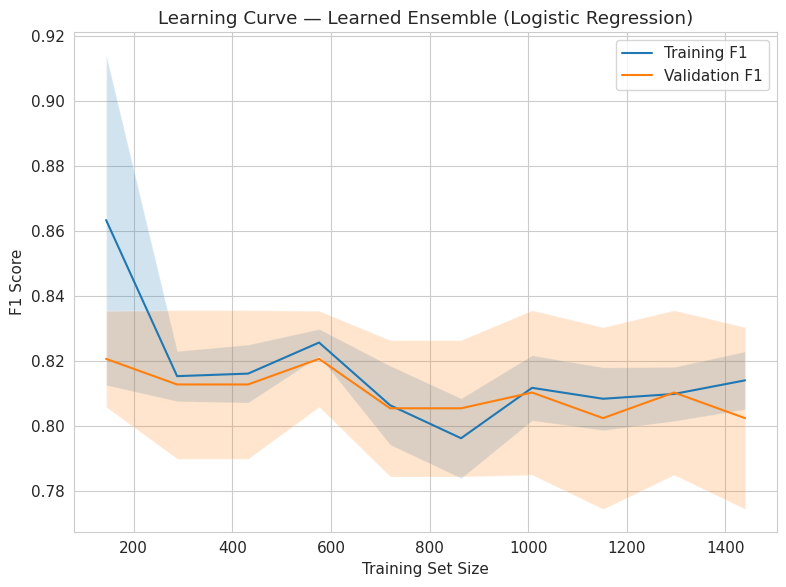

In [ ]:
print("Generating learning curves for Learned Ensemble...\n")

X = np.column_stack([
    1 - test_df['token_overlap'].values,
    1 - test_df['bertscore_f1'].values,
    (test_df['token_overlap'].values < 0.70).astype(int),
    (test_df['bertscore_f1'].values < 0.80).astype(int),
    test_df['token_overlap'].values * test_df['bertscore_f1'].values
])

y = test_df['binary_label'].values

lr = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)

train_sizes, train_scores, val_scores = learning_curve(
    lr,
    X,
    y,
    cv=5,
    scoring=make_scorer(f1_score),
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training F1')
plt.plot(train_sizes, val_mean, label='Validation F1')

plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)

plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve — Learned Ensemble (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Creating detection method comparison visualization...


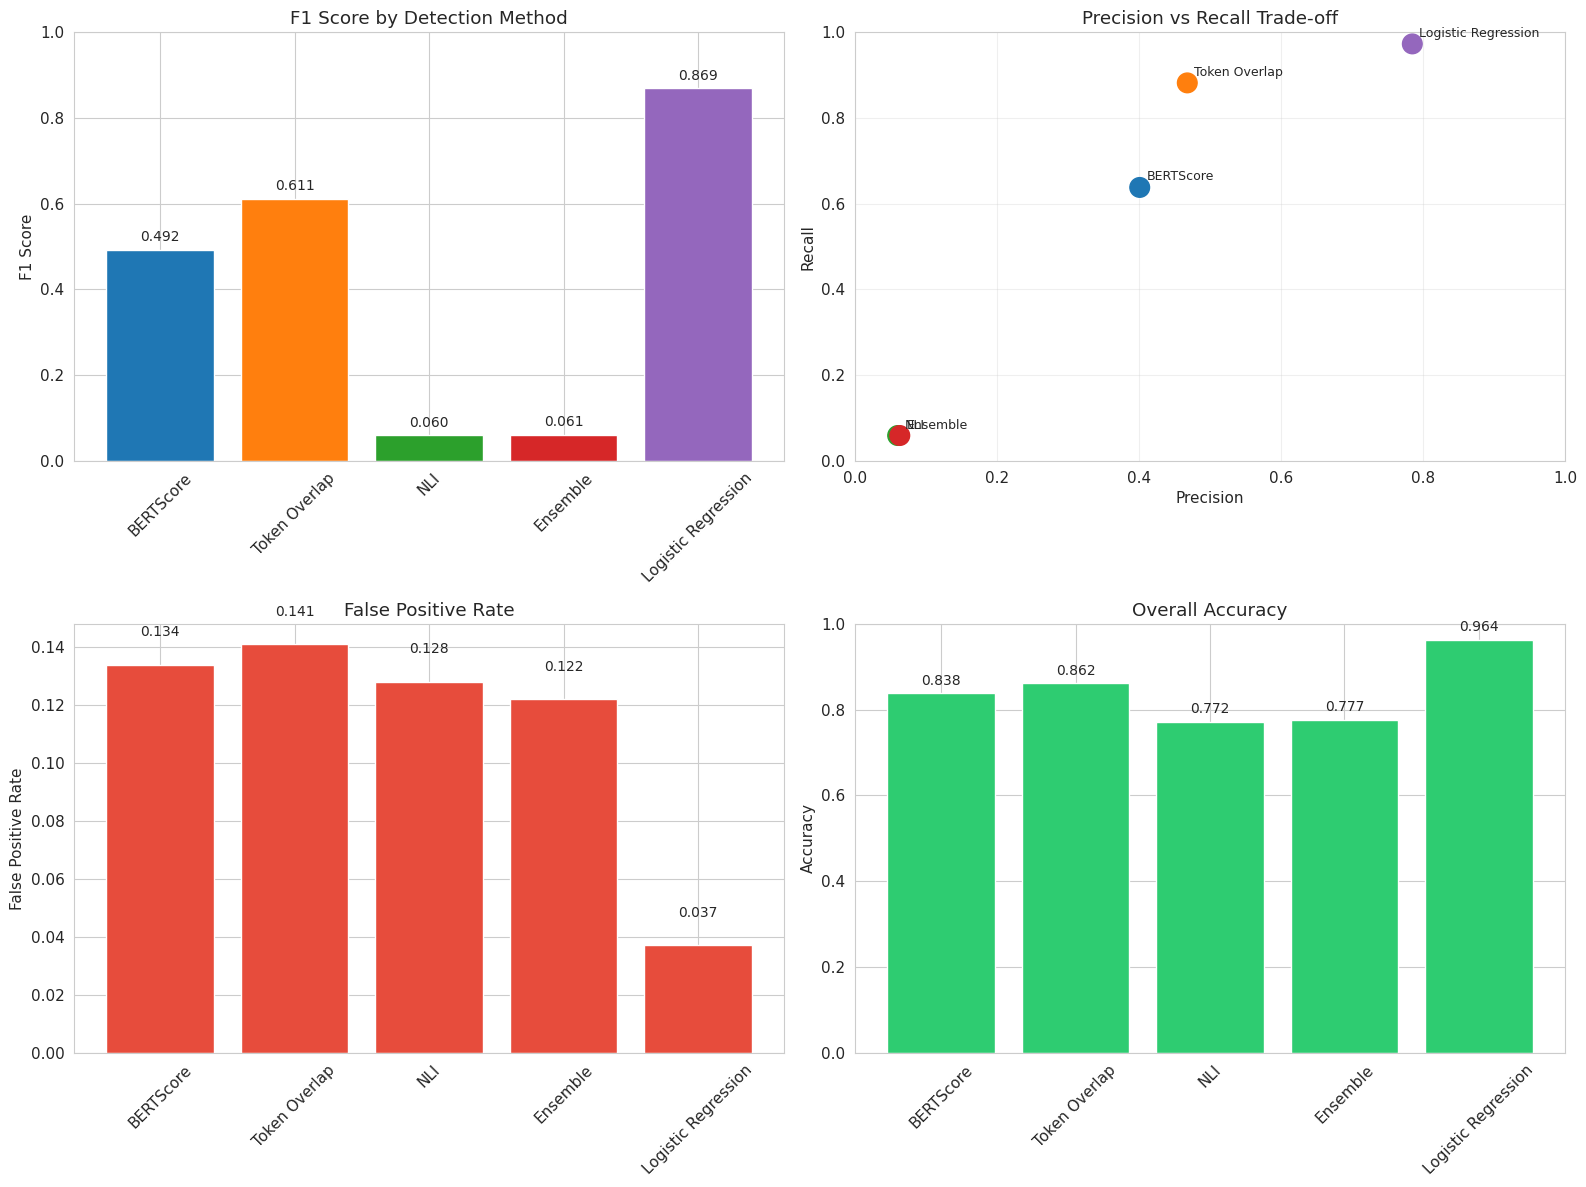

Saved: detection_comparison.png


In [ ]:
print("Creating detection method comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_df = results_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'FPR']:
    plot_df[col] = plot_df[col].astype(float)

plot_df = plot_df[plot_df['Method'] != 'Ground Truth']

colors_for_methods = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

axes[0, 0].bar(plot_df['Method'], plot_df['F1'], color=colors_for_methods)
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('F1 Score by Detection Method')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(plot_df['F1']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

axes[0, 1].scatter(plot_df['Precision'], plot_df['Recall'], s=200,
                   c=colors_for_methods)
for i, method in enumerate(plot_df['Method']):
    axes[0, 1].annotate(method,
                       (plot_df['Precision'].iloc[i], plot_df['Recall'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Precision vs Recall Trade-off')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].bar(plot_df['Method'], plot_df['FPR'], color=['#e74c3c']*len(plot_df))
axes[1, 0].set_ylabel('False Positive Rate')
axes[1, 0].set_title('False Positive Rate')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(plot_df['FPR']):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

axes[1, 1].bar(plot_df['Method'], plot_df['Accuracy'], color=['#2ecc71']*len(plot_df))
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Overall Accuracy')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(plot_df['Accuracy']):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: detection_comparison.png")

Creating confusion matrix heatmaps...


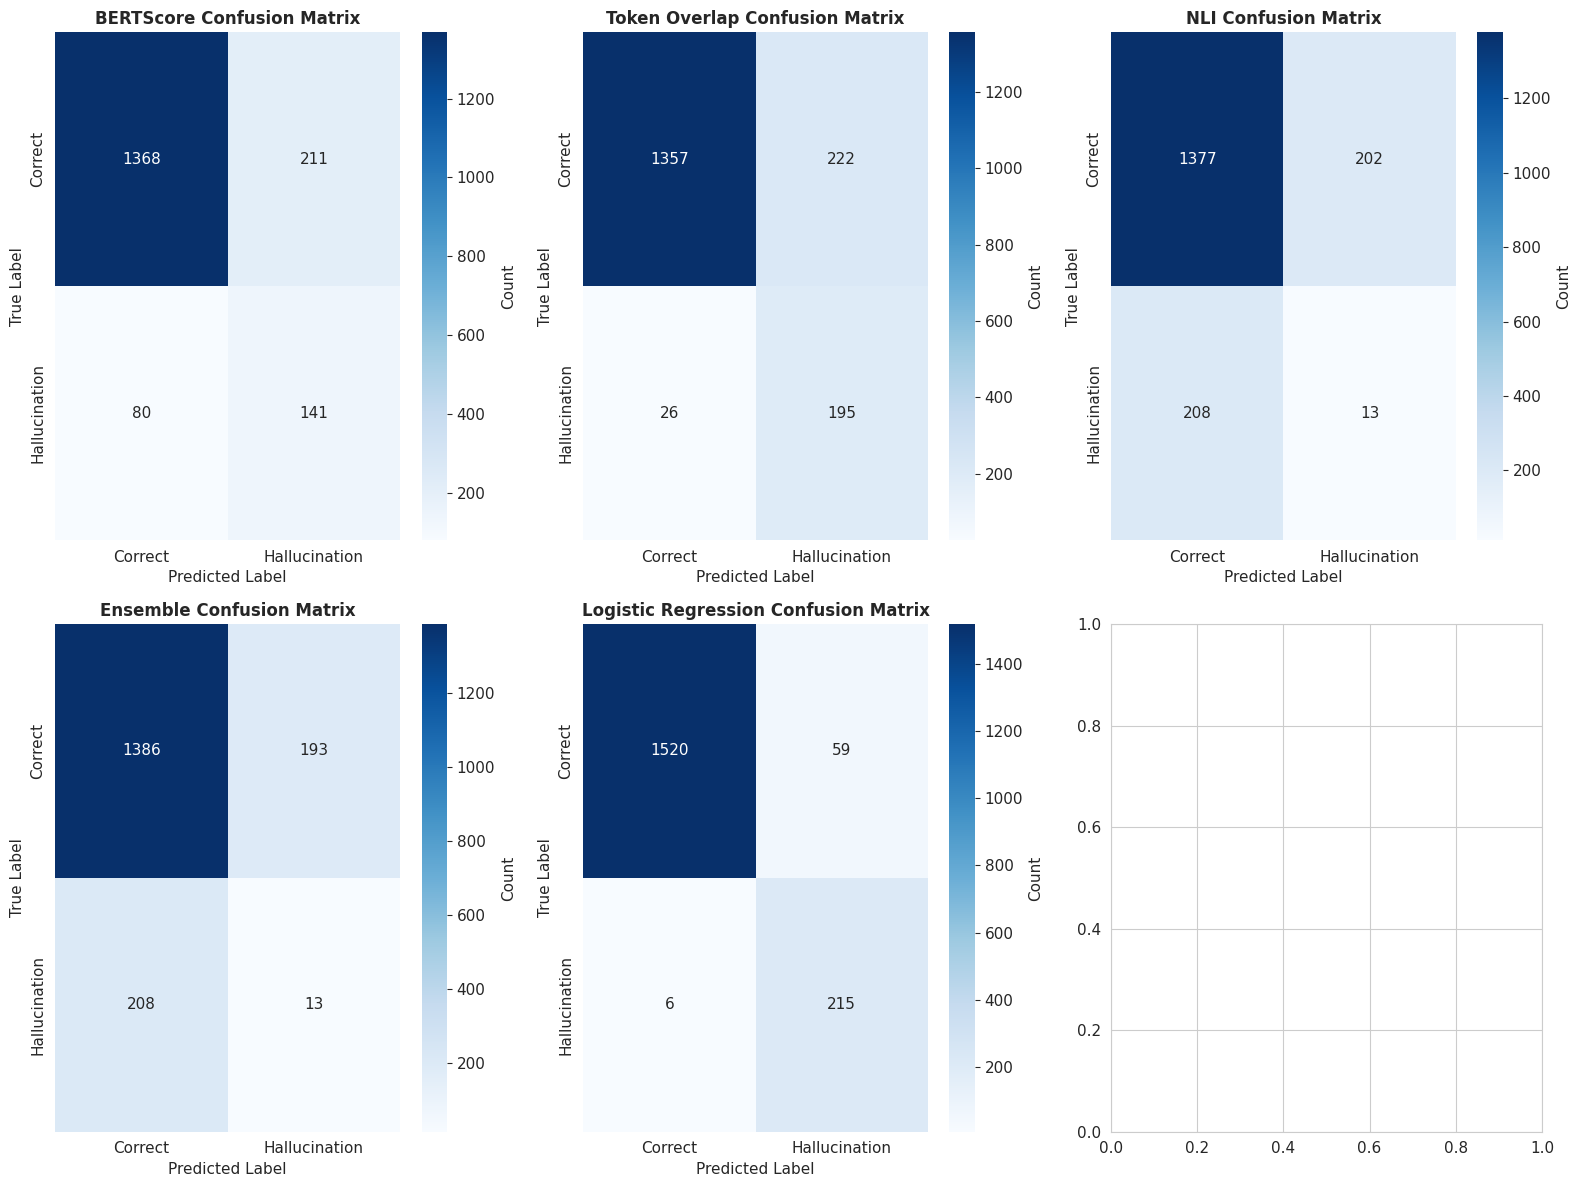

Saved: confusion_matrices.png


In [ ]:
print("Creating confusion matrix heatmaps...")

fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.ravel()

detection_methods = ['bertscore_pred', 'token_pred', 'nli_pred', 'ensemble_pred', 'lr_preds_opt']
method_names = ['BERTScore', 'Token Overlap', 'NLI', 'Ensemble', 'Logistic Regression']

for idx, (pred_col, method_name) in enumerate(zip(detection_methods, method_names)):
    y_true = test_df['binary_label']
    y_pred = test_df[pred_col]

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Correct', 'Hallucination'],
                yticklabels=['Correct', 'Hallucination'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{method_name} Confusion Matrix', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: confusion_matrices.png")

Analyzing hallucination distribution by resume field...

Hallucination by Field:
             field  Hallucinations  Total  Hallucination Rate
          ai_score              15    200               0.075
    certifications               4    200               0.020
         education               5    200               0.025
  experience_years              53    200               0.265
              name               0    200               0.000
    projects_count               0    200               0.000
salary_expectation              54    200               0.270
            skills              36    200               0.180
       target_role              54    200               0.270


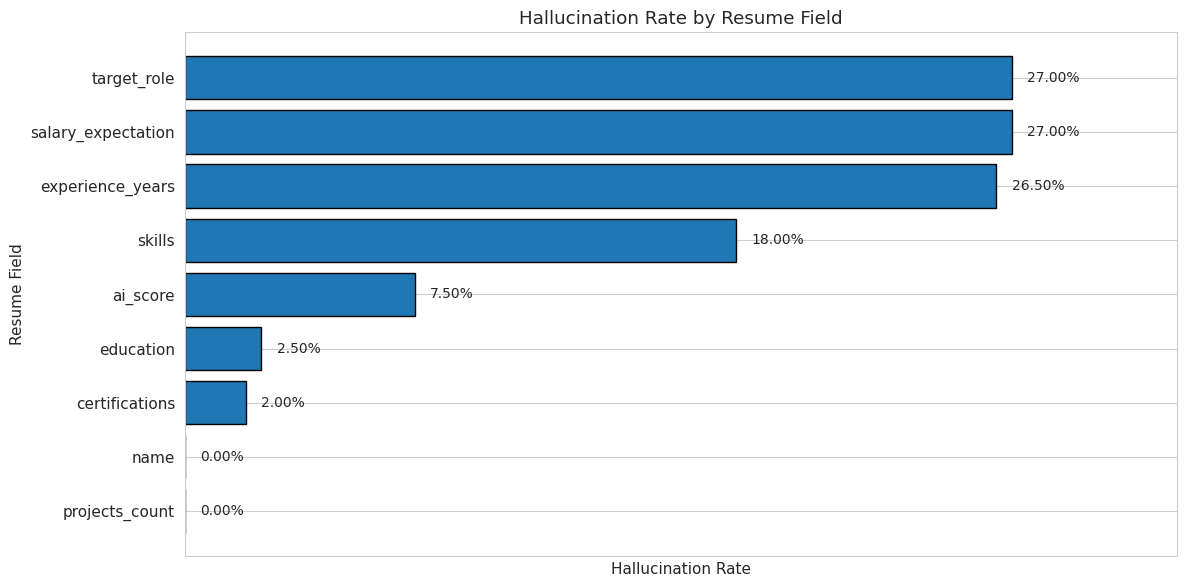

Saved: hallucination_distribution.png


In [ ]:
print("Analyzing hallucination distribution by resume field...")

field_stats = test_df.groupby('field').agg({
    'binary_label': ['sum', 'count', 'mean']
}).round(3)

field_stats.columns = ['Hallucinations', 'Total', 'Hallucination Rate']
field_stats = field_stats.reset_index()

print("\nHallucination by Field:")
print(field_stats.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))

field_stats_sorted = field_stats.sort_values('Hallucination Rate', ascending=True)

bars = ax.barh(field_stats_sorted['field'], field_stats_sorted['Hallucination Rate'], edgecolor='black')

ax.set_xlabel('Hallucination Rate')
ax.set_ylabel('Resume Field')
ax.set_title('Hallucination Rate by Resume Field')
ax.set_xlim([0, max(field_stats_sorted['Hallucination Rate']) * 1.2])
ax.set_xticks([]) # Remove x-axis tick labels

for i, (bar, value) in enumerate(zip(bars, field_stats_sorted['Hallucination Rate'])):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
           f'{value:.2%}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('hallucination_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: hallucination_distribution.png")

Creating confusion matrix heatmaps...


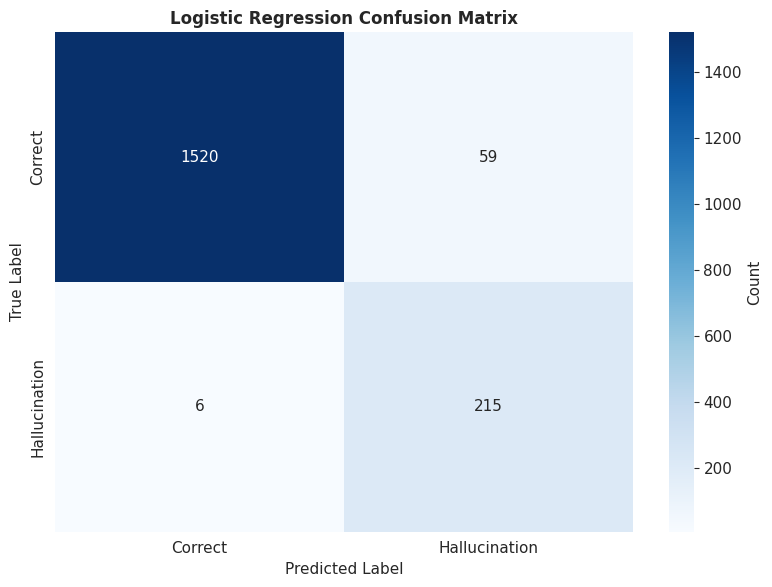

Saved: log_confusion_matrices.png


In [ ]:
print("Creating confusion matrix heatmaps...")

fig, ax = plt.subplots(figsize=(8, 6))

detection_methods = ['lr_preds_opt']
method_names = ['Logistic Regression']

# Since there's only one method, we can directly use 'ax' instead of looping and indexing
pred_col = detection_methods[0]
method_name = method_names[0]

y_true = test_df['binary_label']
y_pred = test_df[pred_col]

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Correct', 'Hallucination'],
            yticklabels=['Correct', 'Hallucination'],
            cbar_kws={'label': 'Count'})
ax.set_title(f'{method_name} Confusion Matrix', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('log_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: log_confusion_matrices.png")

---

## Discussion

- Logistic Ensemble Regression model givees the best result when used with Token Overlap and BERTScore
- Integrating NLI into the ensemble method brings down the F1 score and accuracy of the model
- NLI has no impact in the Logistic Ensemble Regression model

colab research link: https://colab.research.google.com/drive/1BzGOaJOKs4y9ZK60b93f5RfKbiltpuAZ?usp=sharing